In [3]:
# 导入包
import pandas as pd
import numpy as np

# 在notebook内绘图
import matplotlib.pyplot as plt
%matplotlib inline

# 设置图形大小
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 20, 10

In [52]:
# 导入所需的库
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [1]:
#前準備１　データセットの導入
import pandas as pd

gpb=pd.read_csv('data/gpb.csv',encoding="shift-jis")
gpt=pd.read_csv('data/gp_each10min.csv',encoding="shift-jis")

#前準備５　モデル変数表を作成

TVlist=["FTV","NTV"]
Weeklist=["月","火","水","木","金","土","日"]
Timelist=["19:10:00","19:40:00","20:10:00","20:40:00","21:10:00","21:40:00","22:10:00","22:40:00"]
modellist=[]

for TV in TVlist:
    for Week in Weeklist:
        for Time in Timelist:
            
            Time_split=Time.split(":")
            SaveFileName=TV+"_"+Week+Time_split[0]+Time_split[1]
            model_input=TV,Week,Time,SaveFileName
            modellist.append(model_input)
            
pd.DataFrame(modellist)

,0,1,2,3
0,FTV,月,19:10:00,FTV_月1910
1,FTV,月,19:40:00,FTV_月1940
2,FTV,月,20:10:00,FTV_月2010
3,FTV,月,20:40:00,FTV_月2040
4,FTV,月,21:10:00,FTV_月2110
5,FTV,月,21:40:00,FTV_月2140
6,FTV,月,22:10:00,FTV_月2210
7,FTV,月,22:40:00,FTV_月2240
8,FTV,火,19:10:00,FTV_火1910
9,FTV,火,19:40:00,FTV_火1940


In [132]:
##################ここから開始
import warnings
warnings.filterwarnings('ignore')

#抽出データを指定
n=1
print(modellist[n])
select_TV,select_Week,select_Time,SaveFileName=modellist[n]

print("■局：",select_TV)
print("■曜日・時刻：",select_Week,"/",select_Time)
print("■ファイル名：",SaveFileName)

#局データを選ぶ
df_ftv=gpt.loc[(gpt['局'] == select_TV)]
df_ftv_rates=df_ftv[["datetime","視聴率（世帯）","曜日","timestamp"]]

#save datetime series as datetime formart
df_ftv_rates["datetime"]=pd.to_datetime(df_ftv_rates.datetime)
#set datetime series as index
df_ftv_rates=df_ftv_rates.set_index('datetime')

#曜日・時刻データを選ぶ
df_loc=df_ftv_rates.loc[(df_ftv_rates['曜日'] == select_Week)]
locs=df_loc.index.indexer_at_time(select_Time)
ts_loc=df_loc.iloc[locs]

#データに番組情報を追加
ftv_code=[]
ftv_title=[]

for index,row in ts_loc.iterrows():
    t=row.timestamp
    debug=0
    for a,b,c in zip(gpb.datetimets,gpb.endtimets,gpb["Unnamed: 0"]):
        if t in range(a,b):
            if gpb["局"][c]==select_TV:
                ftv_code.append(gpb["番組分類コード"][c])
                ftv_title.append(gpb["メインタイトル"][c])
                debug=1
            else:
                pass
        else:
            pass
        
    if debug==0:
        ftv_code.append("-")
        ftv_title.append("-")
    else:
        pass

ts_loc["番組分類コード"]=ftv_code
ts_loc["メインタイトル"]=ftv_title


#レギュラー番組の検定
import collections
ct=collections.Counter(ftv_title)
dc={}
for k,v in ct.most_common(100):   # 一度pd.Seriesに変換
    dc[k]=v

rbg=pd.DataFrame(pd.Series(dc),columns=["期間内放送回数"])
bangumi_name=rbg.index[0].replace("\u3000","")
print("■レギュラー番組名：",bangumi_name)
rbg.head()

('FTV', '月', '19:40:00', 'FTV_月1940')
■局： FTV
■曜日・時刻： 月 / 19:40:00
■ファイル名： FTV_月1940
■レギュラー番組名： ネプリーグ


,期間内放送回数
ネプリーグ,85
ＦＮＳ番組対抗オールスター春の祭典目利き王決定戦,2
ＦＩＶＢワールドカップバレーボール２０１９女子,2
新春スカッとジャパン内村もドラマに登場！３時間半ＳＰ,1
ネプリーグＳＰ・林先生が全問出題！インテリ芸能人常識ランキン,1


In [133]:
rbg.to_csv('data/output/同時刻放送番組一覧/'+SaveFileName+"_"+"同時刻放送番組一覧"+'.csv',encoding='cp932', index=True, header=True)
#bangumi_name="ザ！鉄腕！ＤＡＳＨ！"

#レギュラー番組のみを抽出して確認
#loc2=ts_loc[ts_loc["メインタイトル"].str.contains("ネプリーグ")]

#イレギュラーの視聴率を2点推定法で修正
import numpy as np

ftv_na=[]
Regular=0

for index,row in ts_loc.iterrows():
    if bangumi_name in row["メインタイトル"]:
        ftv_na.append(row["視聴率（世帯）"])
        Regular+=1
    else:
        ftv_na.append(np.nan)
ts_loc["視聴率（修正）"]=ftv_na
ts_loc=ts_loc.apply(pd.Series.interpolate)

#途中開始番組について、開始日からデータを抽出

def StartTimeCheck(input_data):
    for n in range(len(ts_loc)):
        if np.isnan(input_data["視聴率（修正）"][n]):
            pass
        else:
            output_data=input_data[n:]
            break
    return output_data

ts_loc_2=StartTimeCheck(ts_loc)

#予測に利用する時系列データ（tsデータ）を作成
ts=ts_loc_2["視聴率（修正）"]

In [134]:
memory=36

# 创建数据框
new_data=ts.to_frame()

# 创建训练集和验证集
dataset = new_data.values

train = dataset[:100]
valid = dataset[100:]

# 将数据集转换为x_train和y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(memory,len(train)):
    x_train.append(scaled_data[i-memory:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# 创建和拟合LSTM网络
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

# 使用过去值来预测246个值
inputs = new_data[len(new_data) - len(valid) - memory:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(memory,inputs.shape[0]):
    X_test.append(inputs[i-memory:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Epoch 1/1
 - 2s - loss: 0.0515


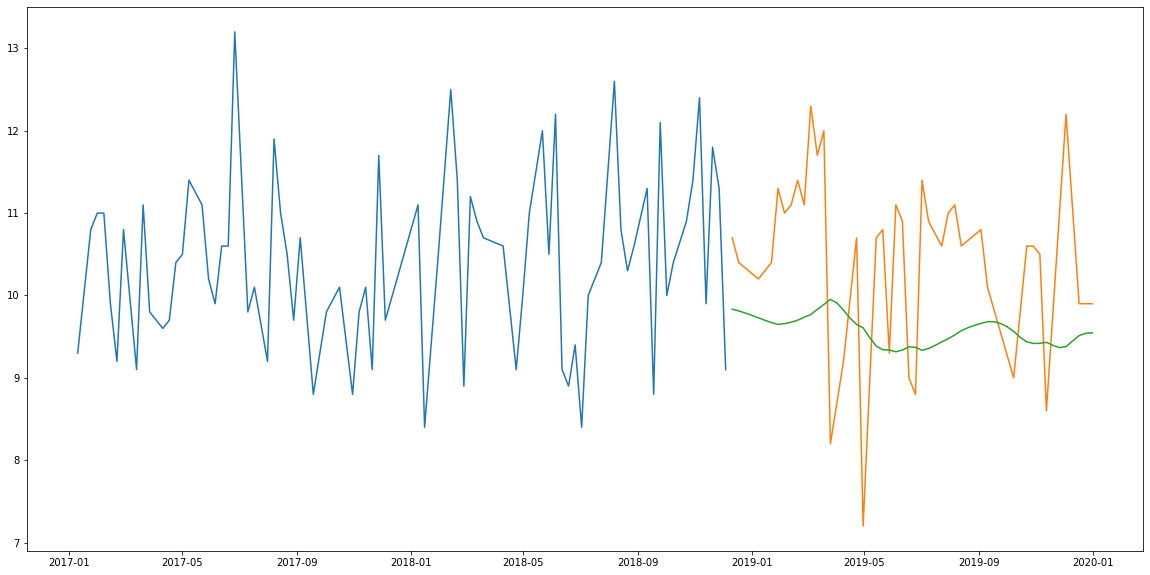

In [136]:
# 在notebook内绘图
import matplotlib.pyplot as plt
%matplotlib inline

# 设置图形大小
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

# 用于绘图
train = new_data[:100]
valid = new_data[100:]
valid['Predictions'] = closing_price
plt.plot(train['視聴率（修正）'])
plt.plot(valid[['視聴率（修正）','Predictions']])

In [137]:
t,p=valid["2019-9":"2019-11"]['視聴率（修正）'],valid["2019-9":"2019-11"]['Predictions']

#RMSE
from sklearn.metrics import mean_squared_error
rmse=np.sqrt(mean_squared_error(t, p))
rmse=round(rmse,2)
print("RMSE",rmse)

#MAPE
import numpy as np
mape=np.mean(np.abs((p - t) / t)) * 100
mape=round(mape,2)
print("MAPE",mape)

RMSE 0.85
MAPE 7.04


In [138]:
#自動化

for n in range(24):
    print(modellist[n])
    select_TV,select_Week,select_Time,SaveFileName=modellist[n]

    print("■局：",select_TV)
    print("■曜日・時刻：",select_Week,"/",select_Time)
    print("■ファイル名：",SaveFileName)

    #局データを選ぶ
    df_ftv=gpt.loc[(gpt['局'] == select_TV)]
    df_ftv_rates=df_ftv[["datetime","視聴率（世帯）","曜日","timestamp"]]

    #save datetime series as datetime formart
    df_ftv_rates["datetime"]=pd.to_datetime(df_ftv_rates.datetime)
    #set datetime series as index
    df_ftv_rates=df_ftv_rates.set_index('datetime')

    #曜日・時刻データを選ぶ
    df_loc=df_ftv_rates.loc[(df_ftv_rates['曜日'] == select_Week)]
    locs=df_loc.index.indexer_at_time(select_Time)
    ts_loc=df_loc.iloc[locs]

    #データに番組情報を追加
    ftv_code=[]
    ftv_title=[]

    for index,row in ts_loc.iterrows():
        t=row.timestamp
        debug=0
        for a,b,c in zip(gpb.datetimets,gpb.endtimets,gpb["Unnamed: 0"]):
            if t in range(a,b):
                if gpb["局"][c]==select_TV:
                    ftv_code.append(gpb["番組分類コード"][c])
                    ftv_title.append(gpb["メインタイトル"][c])
                    debug=1
                else:
                    pass
            else:
                pass

        if debug==0:
            ftv_code.append("-")
            ftv_title.append("-")
        else:
            pass

    ts_loc["番組分類コード"]=ftv_code
    ts_loc["メインタイトル"]=ftv_title


    #レギュラー番組の検定
    import collections
    ct=collections.Counter(ftv_title)
    dc={}
    for k,v in ct.most_common(100):   # 一度pd.Seriesに変換
        dc[k]=v

    rbg=pd.DataFrame(pd.Series(dc),columns=["期間内放送回数"])
    bangumi_name=rbg.index[0].replace("\u3000","")
    print("■レギュラー番組名：",bangumi_name)

    rbg.to_csv('data/output/同時刻放送番組一覧/'+SaveFileName+"_"+"同時刻放送番組一覧"+'.csv',encoding='cp932', index=True, header=True)
    #bangumi_name="ザ！鉄腕！ＤＡＳＨ！"

    #レギュラー番組のみを抽出して確認
    #loc2=ts_loc[ts_loc["メインタイトル"].str.contains("ネプリーグ")]

    #イレギュラーの視聴率を2点推定法で修正
    import numpy as np

    ftv_na=[]
    Regular=0

    for index,row in ts_loc.iterrows():
        if bangumi_name in row["メインタイトル"]:
            ftv_na.append(row["視聴率（世帯）"])
            Regular+=1
        else:
            ftv_na.append(np.nan)
    ts_loc["視聴率（修正）"]=ftv_na
    ts_loc=ts_loc.apply(pd.Series.interpolate)

    #途中開始番組について、開始日からデータを抽出

    def StartTimeCheck(input_data):
        for n in range(len(ts_loc)):
            if np.isnan(input_data["視聴率（修正）"][n]):
                pass
            else:
                output_data=input_data[n:]
                break
        return output_data

    ts_loc_2=StartTimeCheck(ts_loc)

    #予測に利用する時系列データ（tsデータ）を作成
    ts=ts_loc_2["視聴率（修正）"]

    memory=36

    # 创建数据框
    new_data=ts.to_frame()

    # 创建训练集和验证集
    dataset = new_data.values

    train = dataset[:100]
    valid = dataset[100:]

    # 将数据集转换为x_train和y_train
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    x_train, y_train = [], []
    for i in range(memory,len(train)):
        x_train.append(scaled_data[i-memory:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    # 创建和拟合LSTM网络
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

    # 使用过去值来预测246个值
    inputs = new_data[len(new_data) - len(valid) - memory:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)

    X_test = []
    for i in range(memory,inputs.shape[0]):
        X_test.append(inputs[i-memory:i,0])
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)


    valid = new_data[100:]
    valid['Predictions'] = closing_price

    t,p=valid["2019-9":"2019-11"]['視聴率（修正）'],valid["2019-9":"2019-11"]['Predictions']

    #RMSE
    from sklearn.metrics import mean_squared_error
    rmse=np.sqrt(mean_squared_error(t, p))
    rmse=round(rmse,2)
    print("RMSE",rmse)

    #MAPE
    import numpy as np
    mape=np.mean(np.abs((p - t) / t)) * 100
    mape=round(mape,2)
    print("MAPE",mape)

('FTV', '月', '19:10:00', 'FTV_月1910')
■局： FTV
■曜日・時刻： 月 / 19:10:00
■ファイル名： FTV_月1910
■レギュラー番組名： ネプリーグ
Epoch 1/1
 - 2s - loss: 0.0771
RMSE 1.54
MAPE 16.92
('FTV', '月', '19:40:00', 'FTV_月1940')
■局： FTV
■曜日・時刻： 月 / 19:40:00
■ファイル名： FTV_月1940
■レギュラー番組名： ネプリーグ
Epoch 1/1
 - 2s - loss: 0.0608
RMSE 0.86
MAPE 7.09
('FTV', '月', '20:10:00', 'FTV_月2010')
■局： FTV
■曜日・時刻： 月 / 20:10:00
■ファイル名： FTV_月2010
■レギュラー番組名： 痛快ＴＶスカッとジャパン
Epoch 1/1
 - 2s - loss: 0.0730
RMSE 0.84
MAPE 8.46
('FTV', '月', '20:40:00', 'FTV_月2040')
■局： FTV
■曜日・時刻： 月 / 20:40:00
■ファイル名： FTV_月2040
■レギュラー番組名： 痛快ＴＶスカッとジャパン
Epoch 1/1
 - 2s - loss: 0.0787
RMSE 1.37
MAPE 13.85
('FTV', '月', '21:10:00', 'FTV_月2110')
■局： FTV
■曜日・時刻： 月 / 21:10:00
■ファイル名： FTV_月2110
■レギュラー番組名： 貴族探偵
Epoch 1/1
 - 2s - loss: 0.0170
RMSE 0.02
MAPE 0.17
('FTV', '月', '21:40:00', 'FTV_月2140')
■局： FTV
■曜日・時刻： 月 / 21:40:00
■ファイル名： FTV_月2140
■レギュラー番組名： 貴族探偵
Epoch 1/1
 - 2s - loss: 0.0486
RMSE 0.07
MAPE 0.66
('FTV', '月', '22:10:00', 'FTV_月2210')
■局： FTV
■曜日・時刻： 月 / 22:10:00
■

IndexError: tuple index out of range